## 实验题目5 高斯(Gauss)列主元消去法

### 实验简介

本实验为高斯列主元消去法，需要完成使用高斯消元法代码的编写，并对实验题目进行求解。

本次实验过程中，主要为学习高斯消元法的代码写法，同时充分利用矩阵的初等行变换的特点，分别实现了高斯消元、显式消元和隐式消元的`Julia`代码，同时绘制了各写法求解时的时间消耗和求解矩阵阶数的关系图，注意所绘制图像横坐标为样本数而非阶数，每相邻两个样本的阶数之差为5。

实验的目的为使用高斯列主元消元法求解线性方程组。

该实验报告主要分为7个部分，大纲罗列如下：

- 实验简介：即本部分的所有内容
- **数学原理**：即高斯列主元消元法的数学问题定义和求解公式
- **代码实现**：使用`Julia`语言，根据数学原理，编写实验代码
- 测试代码：对于程序基本的正确性、性能的测试代码
  - Test 1 - Correctnesss：使用随机生成的高阶矩阵对程序的正确性进行基本的检验，使用`lib solver`与编写的高斯消元结果向量之差的范数来衡量结果的精确程度。
  - Test 2 - Performance：首先是对各算法求解高阶线性方程组的时间消耗进行统计，然后绘制出方程组求解时间随矩阵阶数变化的折线图，注意横坐标并非阶数而是样本序号，样本从1阶矩阵到4000阶矩阵，每两个连续样本阶数之差为5。
- **实验题目**：实验指导书中所要求的求解的线性方程组，以矩阵形式给出，各题目均将输入矩阵打印到控制台以便于观察，这之后同时提供`lib solver`和`my gauss solver`的解，二者结果精确到小数点后6位完全一致，说明求解正确。
  - **执行代码**：本部分是实验代码进行运行时封装的部分，将函数的调用细节隐藏在show_result()函数内部，便于直接从外部使用特定参数对函数进行调用。
  - **问题1**：此题结果实验指导书中已给出，均为`[1, 1, 1, 1]`，用于对算法正确性进行检查。
  - **问题2**：此题为线性方程组求解的问题，直接调用写好的求解函数`gauss()`即可。
- 总结：因无思考题，此处对于本实验代码进行简单的总结，当前问题和后续的优化方向。
- 参考资料：本次实验过程中查阅的参考资料

### 数学原理

给定方程组
$$
\boldsymbol{Ax}=\boldsymbol{b},
$$
其中,$\boldsymbol{A}=\left( a_{ij} \right) _{n\times n}$是非奇异阵,$\boldsymbol{x}=\left( x_1,x_2,\cdots ,x_n \right) ^T,\boldsymbol{b}=\left( b_1,b_2,\cdots ,b_n \right) ^T$.写成分量形式如下
$$
\sum_{j=1}^n{a_{ij}x_j}=b_i,i=1,2,\cdots ,n.
$$
为方便讨论，我们将方程组写成如下形式
$$
\begin{cases}
	a_{11}x_1+a_{12}x_2+\cdots a_{1n}x_n=a_{1,n+1}\\
	a_{21}x_1+a_{22}x_2+\cdots a_{2n}x_n=a_{2,n+1}\\
	\,\,                  \vdots\\
	a_{n1}x_n+a_{n2}x_2+\cdots a_{nn}x_n=a_{n,n+1}\\
\end{cases}
$$
其中，记$a_{i,n+1}=b_{i},i=1,2,\cdots,n.$

第k次消元为先选择当前第k列最大元素所在的行，然后与第k行进行交换。即先选列主元(*pivoting*)，在代码中由封装的`pivoting!()`函数实现该功能，然后交换两行，代码中由`swaprows!()`函数实现。

消元时，每次计算当前行首元素与接下来$n-k+1$行该列元素的比值的倒数$m_{ik}$，然后将此$n-k+1$行减去当前行（第k行）乘上所求比值，完成当次消元，即

$$
\begin{aligned}
m_{ik}&=a_{ik}^{\left( k-1 \right)}/a_{kk}^{\left( k-1 \right)},&i=k+1,k+2,\cdots ,n.
\\
a_{ij}&=a_{ij}-m_{ik}\cdot a_{kj}^{\left( k-1 \right)},&i=k+1,k+2,\cdots ,n;&j=k+1,k+2,\cdots ,n,n+1
\end{aligned}
$$

当消元完成之后，求得上三角矩阵，此后是回代过程，如下所示
$$
\begin{cases}
	x_n=a_{n,n+1}^{\left( n-1 \right)}/a_{nn}^{\left( n-1 \right)},\\
	x_i=\left[ a_{i,n+1}^{\left( i-1 \right)}-\sum_{j=i+1}^n{a_{ij}^{\left( i-1 \right)}x_j} \right] /a_{ii}^{\left( i-1 \right)},   i=1n-1,n-2,\cdots ,2,1.\\
\end{cases}
$$
然后完成代码编写即可。

### 代码实现

首先导入所需要的包，`LinearAlgebra.jl`是使用线性代数工具的标准库，包含矩阵特征值求解，矩阵求逆，解线性方程组等内置函数，本例中用运算符`\`求解线性方程组。

In [1]:
using Printf
using Plots
using LinearAlgebra
using PrettyTables
using Statistics

#### swaprows

In [2]:
function swaprows!(X::AbstractMatrix, i::Integer, j::Integer)
    @inbounds for k = 1:size(X, 2)
        X[i, k], X[j, k] = X[j, k], X[i, k]
    end
end

swaprows! (generic function with 1 method)

#### pivoting

In [3]:
function pivoting!(A::Matrix{Float64}, k::Integer, n::Integer)
    val, idx = findmax(A[k:n, k])
    idx += k - 1  # index must add previous length that omitted by slice operator
    return val, idx
end
function pivoting!(A::Matrix{Float64}, b::Vector{Float64}, k::Integer, n::Integer, implicit::Bool)
    s = [maximum(A[i, k:n]) for i in k:n]
    if 0 in s
        println("Cannot solve a singular matrix!")
        return
    end
    if implicit
        val, idx = findmax(A[k:n, k] ./ s[1:n-k+1])
    else
        A[k:n, k:n] = A[k:n, k:n] ./ s
        b[k:n] = b[k:n] ./ s
        val, idx = findmax(A[k:n, k])
    end
    idx += k - 1  # index must add previous length that omitted by slice operator
    return val, idx
end

pivoting! (generic function with 2 methods)

#### gauss

In [4]:
# Gauss列主元消去法
function gauss(n, A::Matrix{Float64}, b::Vector{Float64})
    for k = 1:n-1
        # select pivot in columns
        val, idx = pivoting!(A, k, n)
        if val == 0
            println("Cannot solve a singular matrix!")
            return
        end
        # swap rows
        if idx != k
            swaprows!(A, idx, k)
            b[idx], b[k] = b[k], b[idx]
        end
        # elimination
        for i = k+1:n
            m = A[i, k] / A[k, k]
            A[i, :] -= A[k, :] * m
            b[i] -= b[k] * m
        end
    end
    if A[n, n] == 0
        println("Cannot solve a singular matrix!")
        return
    end
    x = similar(b, Float64)
    x[n] = b[n] / A[n, n]
    for k = n-1:-1:1  # the usage of reverse sequence
        x[k] = (b[k] - dot(A[k, k+1:n], x[k+1:n])) / A[k, k]  # something really annoying 
    end
    x
end


gauss (generic function with 1 method)

#### explicit/implicit

In [5]:
# Gauss列主元消去法
function gauss(n, A::Matrix{Float64}, b::Vector{Float64}, implicit::Bool)
    for k = 1:n-1
        # select pivot in columns
        val, idx = pivoting!(A, b, k, n, implicit)
        if val == 0
            println("Cannot solve a singular matrix!")
            return
        end
        # swap rows
        if idx != k
            swaprows!(A, idx, k)
            b[idx], b[k] = b[k], b[idx]
        end
        # elimination
        for i = k+1:n
            m = A[i, k] / A[k, k]
            A[i, :] -= A[k, :] * m
            b[i] -= b[k] * m
        end
    end
    if A[n, n] == 0
        println("Cannot solve a singular matrix!")
        return
    end
    x = similar(b, Float64)
    x[n] = b[n] / A[n, n]
    for k = n-1:-1:1  # the usage of reverse sequence
        x[k] = (b[k] - dot(A[k, k+1:n], x[k+1:n])) / A[k, k]  # something really annoying 
    end
    x
end


gauss (generic function with 2 methods)

### 测试代码

本部分为基本的测试代码，用于对代码的正确性和性能进行初步的检查

#### Test 1 - Correctness

使用随机生成的500阶矩阵对程序的正确性进行基本的检验，使用`lib solver`与三种`gauss solver`结果向量之差的范数来衡量结果的精确程度。

使用的范数为2范数，计算范数的库函数为`norm()`，从计算结果来看，绝对误差大约在1e-10~1e-13数量级，可以认为结果相当的精确。


In [6]:
# test random result of standard library 
# test pass
for i in 1:5
    M = rand(500, 500)
    v = rand(500)
    A, b = copy(M), copy(v)  # ? Todo: move this line into try block will extend compilation time
    try
        # default gauss
        @printf("[vector norm] absolute error: %10.6e\n", norm(A \ b - gauss(size(A, 1), A, b), 2))
        # implicit=false
        A, b = copy(M), copy(v) 
        @printf("[vector norm] absolute error: %10.6e\n", norm(A \ b - gauss(size(A, 1), A, b, false), 2)) 
        # implicit=true
        A, b = copy(M), copy(v)
        @printf("[vector norm] absolute error: %10.6e\n", norm(A \ b - gauss(size(A, 1), A, b, true), 2)) 
    catch SigularException
        @printf("Cannot solve a singular matrix!\n")
    end
    println()
end

[vector norm] absolute error: 1.779781e-12
[vector norm] absolute error: 5.983915e-12
[vector norm] absolute error: 3.740373e-12

[vector norm] absolute error: 2.707323e-12
[vector norm] absolute error: 6.508607e-12
[vector norm] absolute error: 5.296513e-12

[vector norm] absolute error: 2.272272e-12
[vector norm] absolute error: 4.706284e-12
[vector norm] absolute error: 4.289481e-12

[vector norm] absolute error: 2.581938e-11
[vector norm] absolute error: 1.179110e-11
[vector norm] absolute error: 6.608919e-12

[vector norm] absolute error: 6.797016e-12
[vector norm] absolute error: 1.157560e-11
[vector norm] absolute error: 2.105902e-11



#### Test 2 - Performance 

首先是对各算法求解500阶线性方程组的时间消耗进行统计，初步得出求解效率的比较结果。然后绘制出方程组求解时间随矩阵阶数变化的折线图，注意横坐标并非阶数而是样本序号，样本从1阶矩阵到4000阶矩阵，每两个连续样本阶数之差为5。

很明显可以看到，求解高阶矩阵的效率有：`lib solver` >> `my gsolver` > `g implicit` > `g explicit`，显然内置库对于求解的优化远远超出了本人直接写下的高斯消元函数。

从内存分配上看到库函数仅有的`4 allocations`，明显大大的减少了内存分配所消耗的时间，而手写的高斯消元法中间存在较多的不连续且频繁的内存分配导致时间被大量的消耗。

In [7]:
# test random result of standard library 
# test pass
for i in 1:5
    M = rand(500, 500)
    v = rand(500)
    A, b = copy(M), copy(v)
    try
        @printf("lib solver: ")
        @time A \ b

        @printf("my gsolver: ")
        A, b = copy(M), copy(v)
        @time gauss(size(A, 1), A, b)

        @printf("g explicit: ")
        A, b = copy(M), copy(v)
        @time gauss(size(A, 1), A, b, false)  # implicit=false

        @printf("g implicit: ")
        A, b = copy(M), copy(v)
        @time gauss(size(A, 1), A, b, true)  # implicit=true
    catch SigularException
        println("Cannot solve a singular matrix!")
    end
    println()
end

lib solver:   0.009829 seconds (4 allocations: 1.915 MiB)
my gsolver:   0.738466 seconds (500.50 k allocations: 1.936 GiB, 15.91% gc time)
g explicit:   1.210435 seconds (630.65 k allocations: 2.891 GiB, 13.71% gc time)
g implicit:   0.922749 seconds (628.74 k allocations: 2.268 GiB, 12.76% gc time)

lib solver:   0.010037 seconds (4 allocations: 1.915 MiB)
my gsolver:   0.703981 seconds (500.50 k allocations: 1.936 GiB, 14.03% gc time)
g explicit:   1.219443 seconds (630.65 k allocations: 2.891 GiB, 13.59% gc time)
g implicit:   0.921236 seconds (628.74 k allocations: 2.268 GiB, 12.88% gc time)

lib solver:   0.009741 seconds (4 allocations: 1.915 MiB)
my gsolver:   0.705588 seconds (500.50 k allocations: 1.936 GiB, 13.34% gc time)
g explicit:   1.201793 seconds (630.65 k allocations: 2.891 GiB, 12.86% gc time)
g implicit:   0.936341 seconds (628.74 k allocations: 2.268 GiB, 12.83% gc time)

lib solver:   0.009751 seconds (4 allocations: 1.915 MiB)
my gsolver:   0.709221 seconds (500.

接下来是绘制求解时间随矩阵阶数变化的折线图，横坐标是样本序号，样本从1阶矩阵到4000阶矩阵，每两个连续样本阶数之差为5。因本人手写的高斯消元效率过低，求解阶数大于500的矩阵耗时过长，故绘制图像时有所选择。时间单位为秒，包含了生成矩阵所消耗的时间和求解时间，生成矩阵耗时比库函数求解低一个数量级，故可不多作考虑。

此处性能测试时间消耗过大，又因已经绘制了图像，故均作注释处理。

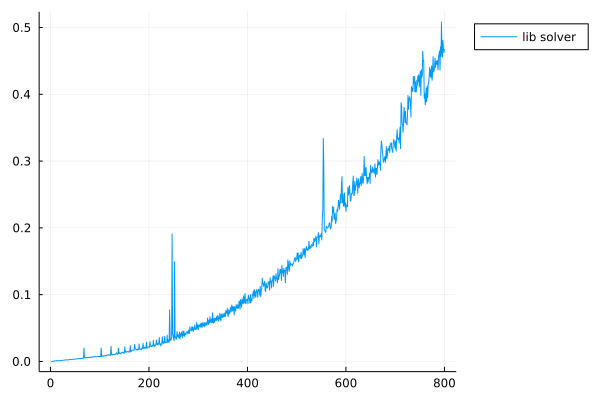

In [8]:
# iter = 1:5:4000
# x = [@elapsed(rand(i,i)\rand(i)) for i = iter]
# plot(x, label="lib solver", legend=:outertopright)

该图中可以见得本人手写的高斯消元耗时远远超出了库函数解法，仅在阶数低于50（横坐标16附近）时大致能和`lib solver`耗时相当。

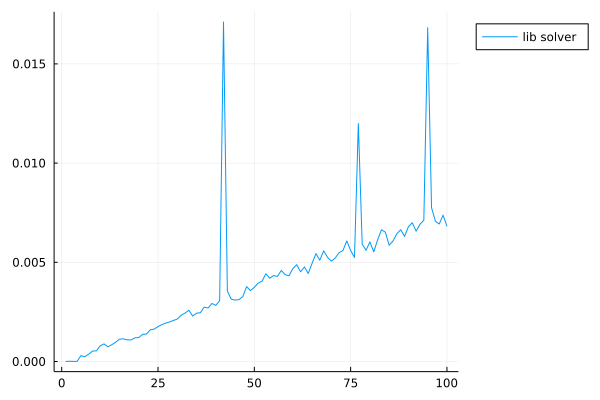

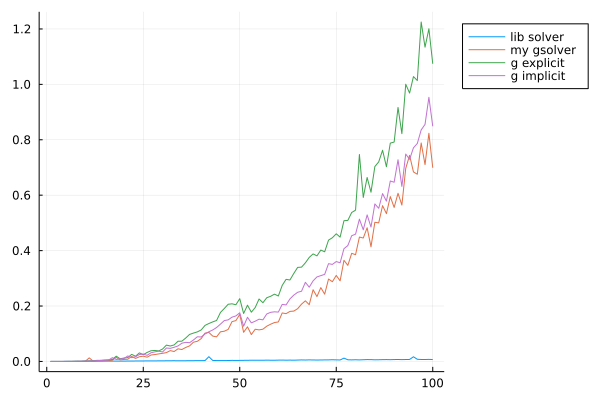

In [9]:
# iter = 1:5:500
# x = [@elapsed(rand(i,i)\rand(i)) for i = iter]
# display(plot(x, label="lib solver", legend=:outertopright))
# x = [@elapsed(gauss(i, rand(i,i), rand(i))) for i = iter]
# plot!(x, label="my gsolver")
# x = [@elapsed(gauss(i, rand(i,i), rand(i), false)) for i = iter]
# plot!(x, label="g explicit")
# x = [@elapsed(gauss(i, rand(i,i), rand(i), true)) for i = iter]
# plot!(x, label="g implicit")

### 实验题目

实验指导书中所要求的求解的线性方程组，均以矩阵形式给出，各题目均将输入矩阵打印到控制台以便于观察，这之后同时提供`lib solver`和`my gauss solver`的解，二者结果精确到小数点后6位完全一致，说明求解正确。

本部分在阶数较小的时候，意外的看到手写的`my gauss solver`效率高于`lib solver`，尽管如此，从上图曲线变化很明显可以注意到`lib solver`求解效率的稳定性。

#### 执行代码

本部分是实验代码进行运行时封装的部分，将函数的调用细节隐藏在show_result()函数内部，便于直接从外部使用特定参数对函数进行调用。

In [10]:
function show_result(A, b)
    n = size(A, 1)
    A = Float64.(A)
    b = Float64.(b)
    
    println("input matrix: [A | b]")
    data=[A repeat([|], inner=(n, 1)) b]
    pretty_table(
        data;
        header_crayon=crayon"bold",
        tf = tf_matrix,
        noheader=true,
        formatters=ft_printf("%11.8f"))
    
    println("lib solver result:")
    pretty_table(
        @time A \ b;
        header_crayon=crayon"bold",
        tf = tf_matrix,
        noheader=true,
        formatters=ft_printf("%11.8f"))
    
    println("my gauss solver result:")
    pretty_table(
        @time gauss(n, A, b);
        header_crayon=crayon"bold",
        tf = tf_matrix,
        noheader=true,
        formatters=ft_printf("%11.8f"))
    # display(@time gauss(n, A, b, false))  # implicit=false
    # display(@time gauss(n, A, b, true))  # implicit=true
end

show_result (generic function with 1 method)

#### 问题 1

##### 1.1

In [11]:
A = [0.4096 0.1234 0.3678 0.2943
     0.2246 0.3872 0.4015 0.1129
     0.3645 0.1920 0.3781 0.0643
     0.1784 0.4002 0.2786 0.3927]
b = [1.1951; 1.1262; 0.9989; 1.2499]
show_result(A, b)

input matrix: [A | b]
┌                                                                    ┐
│  0.40960000   0.12340000   0.36780000   0.29430000  |   1.19510000 │
│  0.22460000   0.38720000   0.40150000   0.11290000  |   1.12620000 │
│  0.36450000   0.19200000   0.37810000   0.06430000  |   0.99890000 │
│  0.17840000   0.40020000   0.27860000   0.39270000  |   1.24990000 │
└                                                                    ┘
lib solver result:
  0.000011 seconds (3 allocations: 384 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000006 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


##### 1.2

In [12]:
A = [136.01  90.860       0       0
     90.860  98.810 -67.590       0
          0 -67.590  132.01  46.260
          0       0  46.260  177.17]
b = [226.87; 122.08; 110.68; 223.43]
show_result(A, b)

input matrix: [A | b]
┌                                                                         ┐
│ 136.01000000   90.86000000    0.00000000    0.00000000  |  226.87000000 │
│  90.86000000   98.81000000  -67.59000000    0.00000000  |  122.08000000 │
│   0.00000000  -67.59000000  132.01000000   46.26000000  |  110.68000000 │
│   0.00000000    0.00000000   46.26000000  177.17000000  |  223.43000000 │
└                                                                         ┘
lib solver result:
  0.000010 seconds (3 allocations: 384 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000006 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


##### 1.3

In [13]:
A = [  1 1/2 1/3 1/4
     1/2 1/3 1/4 1/5
     1/3 1/4 1/5 1/6
     1/4 1/5 1/6 1/7]
b = [25 / 12; 77 / 60; 57 / 60; 319 / 420]
show_result(A, b)

input matrix: [A | b]
┌                                                                    ┐
│  1.00000000   0.50000000   0.33333333   0.25000000  |   2.08333333 │
│  0.50000000   0.33333333   0.25000000   0.20000000  |   1.28333333 │
│  0.33333333   0.25000000   0.20000000   0.16666667  |   0.95000000 │
│  0.25000000   0.20000000   0.16666667   0.14285714  |   0.75952381 │
└                                                                    ┘
lib solver result:
  0.000015 seconds (3 allocations: 384 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000010 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


##### 1.4

In [14]:
A = [10  7  8  7
      7  5  6  5
      8  6 10  9
      7  5  9 10]
b = [32; 23; 33; 31]
show_result(A, b)

input matrix: [A | b]
┌                                                                    ┐
│ 10.00000000   7.00000000   8.00000000   7.00000000  |  32.00000000 │
│  7.00000000   5.00000000   6.00000000   5.00000000  |  23.00000000 │
│  8.00000000   6.00000000  10.00000000   9.00000000  |  33.00000000 │
│  7.00000000   5.00000000   9.00000000  10.00000000  |  31.00000000 │
└                                                                    ┘
lib solver result:
  0.000010 seconds (3 allocations: 384 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000006 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


#### 问题 2


##### 2.1

In [15]:
A = [ 197   305  -206  -804
     46.8  71.3 -47.4  52.0
     88.6  76.4 -10.8  802
     1.45  5.90  6.13  36.5]
b = [136; 11.7; 25.1;  6.60]
show_result(A, b)

input matrix: [A | b]
┌                                                                           ┐
│ 197.00000000  305.00000000  -206.00000000  -804.00000000  |  136.00000000 │
│  46.80000000   71.30000000   -47.40000000    52.00000000  |   11.70000000 │
│  88.60000000   76.40000000   -10.80000000   802.00000000  |   25.10000000 │
│   1.45000000    5.90000000     6.13000000    36.50000000  |    6.60000000 │
└                                                                           ┘
lib solver result:
  0.000009 seconds (3 allocations: 384 bytes)
┌             ┐
│  0.95367911 │
│  0.32095685 │
│  1.07870808 │
│ -0.09010851 │
└             ┘
my gauss solver result:
  0.000009 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  0.95367911 │
│  0.32095685 │
│  1.07870808 │
│ -0.09010851 │
└             ┘


##### 2.2

In [16]:
A = [0.5398  0.7161 -0.5554 -0.2982
     0.5257  0.6924  0.3565 -0.6255
     0.6465 -0.8187 -0.1872  0.1291
     0.5814  0.9400 -0.7779 -0.4042]
b = [0.2058; -0.0503; 0.1070; 0.1859]
show_result(A, b)

input matrix: [A | b]
┌                                                                    ┐
│  0.53980000   0.71610000  -0.55540000  -0.29820000  |   0.20580000 │
│  0.52570000   0.69240000   0.35650000  -0.62550000  |  -0.05030000 │
│  0.64650000  -0.81870000  -0.18720000   0.12910000  |   0.10700000 │
│  0.58140000   0.94000000  -0.77790000  -0.40420000  |   0.18590000 │
└                                                                    ┘
lib solver result:
  0.000053 seconds (3 allocations: 384 bytes)
┌             ┐
│  0.51617730 │
│  0.41521947 │
│  0.10996610 │
│  1.03653922 │
└             ┘
my gauss solver result:
  0.000009 seconds (34 allocations: 3.031 KiB)
┌             ┐
│  0.51617730 │
│  0.41521947 │
│  0.10996610 │
│  1.03653922 │
└             ┘


##### 2.3

In [17]:
A = [10  1  2
      1 10  2
      1  1  5]
b = [13; 13; 7]
show_result(A, b)

input matrix: [A | b]
┌                                                       ┐
│ 10.00000000   1.00000000   2.00000000  |  13.00000000 │
│  1.00000000  10.00000000   2.00000000  |  13.00000000 │
│  1.00000000   1.00000000   5.00000000  |   7.00000000 │
└                                                       ┘
lib solver result:
  0.000009 seconds (3 allocations: 288 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000003 seconds (19 allocations: 1.453 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


##### 2.4

In [18]:
A = [4 -2 -4
    -2 17 10
    -4 10  9]
b = [-2; 25; 15]
show_result(A, b)

input matrix: [A | b]
┌                                                       ┐
│  4.00000000  -2.00000000  -4.00000000  |  -2.00000000 │
│ -2.00000000  17.00000000  10.00000000  |  25.00000000 │
│ -4.00000000  10.00000000   9.00000000  |  15.00000000 │
└                                                       ┘
lib solver result:
  0.000010 seconds (3 allocations: 288 bytes)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘
my gauss solver result:
  0.000004 seconds (19 allocations: 1.453 KiB)
┌             ┐
│  1.00000000 │
│  1.00000000 │
│  1.00000000 │
└             ┘


### 总结

本实验为高斯列主元消元法的实现，以及运用所写代码完成问题的求解，同时熟悉了`Julia`语言的一些内置函数，以提高代码运行效率的细节用法，例如：
 - 使用`findmax()`同时获取向量最大元素及其下标，
 - 使用`@inbounds`宏减少不必要的边界检查，以节约时间
 - 使用`similar()`返回内容任意形状相同的矩阵或者向量
 - 使用`norm()`和`opnorm()`分别计算向量和矩阵的范数
 - 使用`@elapsed`宏获取对应代码运行的时间数值

本次实验代码随能正确完成任务，且在矩阵阶数较低时有高于库函数的运行效率，但较为零散和频繁的内存分配是的函数在处理高阶矩阵时的时间效率远远低于库函数解法。主要的优化方向为分辨出代码中不必要的内存分配部分，但由于当前`Julia`几乎就是默认使用引用传递，不存在`python`语言中的内存消耗问题，优化可能还需要参考编译出的汇编代码，可在函数前加`@code_native`宏来查看。

这是本实验课的最后一个实验，虽然并非最后完成的实验，但在实验报告的整理过程中，通过之前实验完成过程中学习的`PrettyTables.jl`库重写了`show_result()`函数以获得更好的结果呈现方式。

通过这半学期的练习，对于`Julia`语言各个领域库的使用有了基本的了解，方便了日后的深入使用。

### 参考资料

1. julia swapcols fast https://stackoverflow.com/questions/58667332/is-there-a-way-to-swap-columns-in-o1-in-julia
2. julia \_swapcol fast https://discourse.julialang.org/t/swap-cols-rows-of-a-matrix/47904/9
3. julia pivoting https://stackoverflow.com/questions/45396685/what-does-an-exclamation-mark-mean-after-the-name-of-a-function
4. julia pivoting https://people.richland.edu/james/lecture/m116/matrices/pivot.html
5. julia similar https://stackoverflow.com/questions/62142717/julia-quick-way-to-initialise-an-empty-array-thats-the-same-size-as-another
6. moving average pseudocode https://stackoverflow.com/questions/28820904/how-to-efficiently-compute-average-on-the-fly-moving-average
7. julia repeat method https://www.geeksforgeeks.org/creating-array-with-repeated-elements-in-julia-repeat-method/
8. julia repeat usage http://www.jlhub.com/julia/manual/en/function/repeat
9. moving average https://stackoverflow.com/questions/12636613/how-to-calculate-moving-average-without-keeping-the-count-and-data-total
9. 《数值分析原理》吴勃英 46-48
10. 《计算方法实验指导》实验题目 5 高斯(Gauss)列主元消去法